<img src='./img/LogoWekeo_Copernicus_RGB_0.png' align='right' width='20%'></img>

# Tutorial on basic multitemporal vision (data processing)

In this tutorial we will use the WEkEO Jupyterhub to access and analyse data from the Copernicus Sentinel satellites and products from the Copernicus Emergency Management Service (CEMS). A region in northern Corsica has been selected as it contains representative landscape features and process elements which can be used to demonstrate the capabilities and strengths of Copernicus space component and services. In this case we will be studying a fire event from 2017 which occurred in the Olmeta-di-Tuda commune in the Haute-Corse department.

EO images are great at capturing information over large areas in a synoptic or snap-shot fashion, but single images only provide a status and no indication of the dynamics of the landscape. Multiple images allow the identification of changes if the phenomenon of interest has a visible expression in the data. The combination of images from multiple dates in a single visualisation can often show changes without need for detailed analysis of the individual acquisitions.

The tutorial thus comprises the following steps:
1.	[Display true colour Sentinel-2 and CEMS data](#load_sentinel2_CEMS): Open downloaded Sentinel-2 data, read and view the Sentinel-2 data in geographic coordinates as true colour image overlain with a CEMS deliniation map.
2.	[Load and view pre-processed Sentinel-1 SAR data](#sentinel1_vis): Load and view the Sentinel-1 data for the burnt area before, immediatley after and then for a few weeks later in different configurations.
3.	[Comparing the backscattering temporal behaviour](#display_comp): Comparing the temporal behaviour of the Sentinel-1 backscatter between burnt and unburnt areas.

<img src='./img/Multi-vis-banner2.jpg' align='center' width='100%'></img>

## <a id='load_sentinel2_CEMS'></a>1. Display true color Sentinel-2 and CEMS data


Before we beginning the environment must be prepared. This includes importing the various python libraries that will be needed.

### Load required libraries

In [1]:
import rasterio as rio
from rasterio.plot import show
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure # to enhance image display
import geopandas as gpd
#from rasterstats import zonal_stats
from rasterio.mask import mask
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
from rasterstats import zonal_stats
import matplotlib.patches as mpatches

The Sentinel-2 Multiple Spectral Imager (MSI) records 13 spectral bands across the visible and infrared portions of the electromagnetic spectrum at different spatial resolutions from 10 m to 60 m depending on their operation and use. There are currently two Sentinel-2 satellites in suitably phased orbits to give a revisit period of 5 days at the Equator and 2-3 days at European latitudes. Being an optical sensor they are of course also affected by cloud cover and illumination conditions. The Sentinel-2 images are useful as a site reference image. The Sentinel-2 data is already availabe, but can be accessed as shown in the earlier training session. For this training session we will only need a composite true colour image (made up of the blue green and red bands).

As the Sentinel instruments have image widths in excess of 250 km it is useful to select an area of interest (AOI) to subset data down to the region appropriate for analysis and visualisation. The AOI has already been defined and stored as a vector file.

To help with the visualisation of the Sentinel-1 backscatter data a boundary line for the fire is very useful. The Olmeta fire delineation map can be downloaded from the CEMS website at https://emergency.copernicus.eu/mapping/ems-product-component/EMSR214_01OLMETA_01DELINEATION_MAP/1.

The cell below loads the required data and checks the coordinate reference systems.

In [2]:
#Load Sentinenel-2 true color
download_dir_path = os.path.join(os.getcwd(), 'data/from_wekeo')
data_path = os.path.join(os.getcwd(), 'data')

R20 =  os.path.join(download_dir_path, 'S2A_MSIL2A_20170802T101031_N0205_R022_T32TNN_20170802T101051.SAFE/GRANULE/L2A_T32TNN_A011030_20170802T101051/IMG_DATA/R20m') #20 meters resolution folder
TCI =  rio.open(R20+'/L2A_T32TNN_20170802T101031_TCI_20m.jp2') #true color

#Load AOI shapefile
aoi = gpd.read_file('shp/AOI_S2.shp')

#Load EMS Delineation Map 
EMSR214_shp = gpd.read_file("shp/EMSR214_01OLMETA_01DELINEATION_MAP_v1_vector/EMSR214_01OLMETA_01DELINEATION_v1_25000_crisis_information_poly.shp")

#check the coordinate reference system
print(TCI.crs)
print(aoi.crs)
print(EMSR214_shp.crs)

EPSG:32632
epsg:4326
epsg:32632


The AOI data does not have the required CRS, so is reprojected.

In [3]:
#convert AOI'crs to WGS 84 / UTM zone 32N (Sentinel-2 crs)
aoi_proj = aoi.to_crs(epsg=32632) 

The true color is then cropped using the AOI geometry. 

In [4]:
out_image, out_transform = mask(TCI, aoi_proj.geometry, crop=True)
out_meta = TCI.meta.copy()
out_meta.update({"driver": "GTiff",
             "height": out_image.shape[1],
             "width": out_image.shape[2],
             "transform": out_transform})
with rio.open(os.path.join(data_path, "S2_20m_TCI_masked_201223.tif"), "w", **out_meta) as dest:
    dest.write(out_image)

The subsetted Sentinel-2 true colour image is then displayed with the fire delineation boundary overlain. In this particular Sentinel-2 image it is relatively easy to make out the burnt area, but in other cases it may not be so obvious or the optical imagery may not be available due to cloud cover or smoke from other fires.

Text(0.5, 78.0, 'Easting (m)')

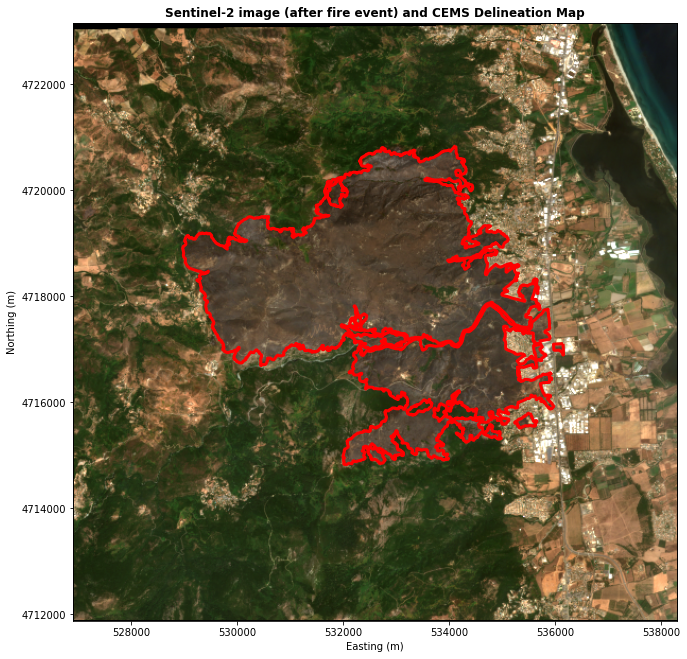

In [5]:
#Plot
TCI_masked = rio.open(os.path.join(data_path, "S2_20m_TCI_masked_201223.tif"))

bounds = (TCI_masked.bounds.left, TCI_masked.bounds.right, \
          TCI_masked.bounds.bottom, TCI_masked.bounds.top)

fig,ax1 = plt.subplots(figsize=(12, 11))

show(TCI_masked, ax=ax1, transform=TCI_masked.transform, title="Sentinel-2 image (after fire event) and CEMS Delineation Map" )

#Add EMS borders on the plot
EMSR214_shp.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=3)

#Set labels and bounds
ax1.set_ylim(bounds[2], bounds[3])
ax1.set_xlim(bounds[0], bounds[1])
ax1.ticklabel_format(axis = 'both', style = 'plain')
ax1.set_ylabel("Northing (m)") # (WGS 84 / UTM zone 32N)
ax1.set_xlabel("Easting (m)")

## <a id='sentinel1_vis'></a>2. Load and view pre-processed Sentinel-1 SAR data

The Sentinel-1 satellites carry an advanced synthetic aperture radar (SAR) instrument to provide all-weather, day-and-night imagery of Earth’s surface. The C-band SAR instrument can have a spatial resolution down to 5 m and a swath width up to 400 km. The orbit has a 12-day repeat cycle and two satellites give a 6 day revisit time. The C-band data is used for change detection, sea ice monitoring, ocean maritime navigation and vegetation mapping. In forests the signal penetrates only into the top layers of the canopy and will experience mostly roughness scattering mixed with a limited amount of volume scattering, but this is enough to detect the disturbance caused by significant fire damage.

The digital number (DN) values recorded in a raw Sentinel-1 image have to be converted to backscatter values of $\sigma^o$. Three SAR images in VH polarization are used for this tutorial, these image have been acquired at the following dates: 9th July 2017 (pre event),  2nd August 2017 (immediately post event) and 14th August 2017 (post event).

The following figure show the ESA SNAP toolbox's graph used for the pre-processing phase.
The SNAP Graph Builder allows the user to assemble graphs from a list of available operators and connect operator nodes to their sources. In this case the data is calibrated to backscatter, a speckle filter is applied to reduce the salt and pepper noise and an ellipsoid correction is used to correct the images to ground range. The full image is then subset and stacked for transfer to the JupyterHub.

<img src='./img/S1_preprocessing_SNAP_graph.PNG' align='center' width='50%'></img>

The following cells read the stacked SAR data and dissaggregate it to show the individual components and also prepares an array to hold an enhanced verion of the stacked image.

In [6]:
#Load the SAR stack 
S1_stack = os.path.join(os.path.join(data_path,"Subset_S1A_IW_GRDH_1SDV_20170709T052746_20170709T052811_017390_01D0C1_D18A_Cal_Spk_EC_Stack_lee7x7.tif"))
src = rio.open(S1_stack)
before = src.read(1)
after_imm = src.read(2)
after_post = src.read(3)
bandnames = ["09Jul2017 (pre event)", "02Aug2017 (immediately post event)", "14Aug2017 (post event)"]

In [7]:
#Prepare the stack of arrays for RGB visualization.
RGB = np.dstack((before, after_imm, after_post))

The function exposure.equalize_hist() from the skimage.exposure module can be used to improve the image visualization.

In [8]:
rgb_stretched=np.ndarray.astype(RGB.copy(),'float32')

for i in range(rgb_stretched.shape[2]):
    rgb_stretched[:,:,i] = np.ndarray.astype(exposure\
    .equalize_hist(rgb_stretched[:,:,i], 
     mask=~np.equal(rgb_stretched[:,:,i],0.)), "float32")
    
    

In the following cell the individual images are displayed to compare backscatter between the three dates. As would be expected the burnt area appears darker in the post event images as there are now less branches etc. to scatter the C-band radiaiton back towards the sensor.

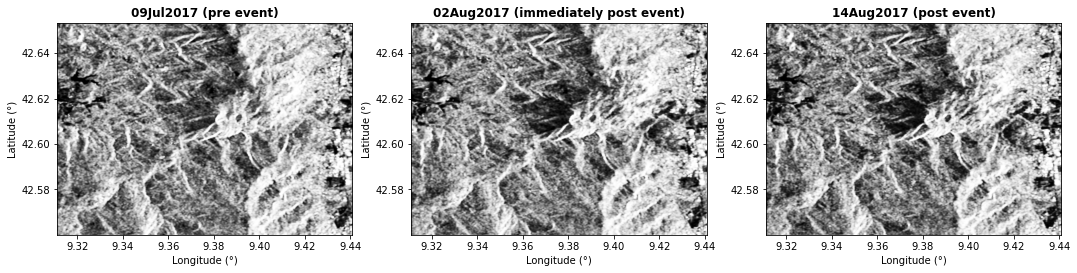

In [9]:
rgb_stretched_move = np.moveaxis(rgb_stretched.squeeze(),-1,0)

#Plot each band of the stack and set axis labels
fig, ax2 = plt.subplots(1,3,figsize=(18,15))
for k in range(3):
    show(rgb_stretched_move[k], ax=ax2[k], transform=src.transform, title = bandnames[k], cmap = "gray")
    ax2[k].set_ylabel("Latitude (°)")
    ax2[k].set_xlabel("Longitude (°)")
    ax2[k].ticklabel_format(axis = 'both', style = 'plain')
    
    

### Display the multi-temporal image composites (RGB) 

The change in backscatter maybe rather subtle depending on the canopy chatracterisitics before the fire and the instensity of the burn (i.e. have the trees been completely destroyed or are they still standing but with only damage to the canopy). A good way to enhance these differences is to stack the images so that the backscatter at different times appears as a different colour. In the cell below the enhanced single band images have been restacked and then overlain with the fire delineation boundary. As the pre-event image with higher backscatter in the burn is dispalyed in red the burnt area also comes out as red with unburnt areas tending to white or grey.

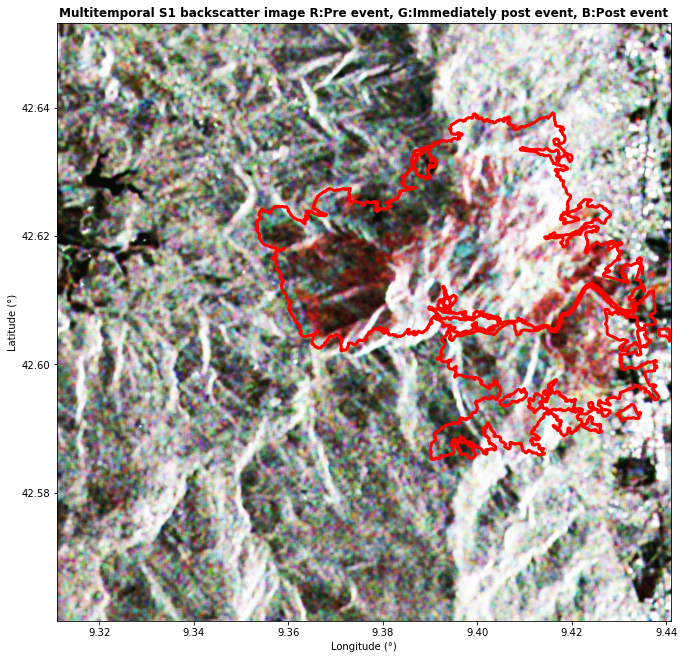

In [10]:
fig, ax3 = plt.subplots(figsize=(12,11))

show(rgb_stretched_move, ax=ax3, transform=src.transform, title = ("Multitemporal S1 backscatter image R:Pre event, G:Immediately post event, B:Post event"))

#Add EMS borders on the plot (eventually)
EMSR214_shp_wgs84 = EMSR214_shp.to_crs(crs = 4326)
EMSR214_shp_wgs84.plot(ax=ax3, facecolor='none', edgecolor='red', linewidth=3)

#Set axis labels
ax3.set_ylabel("Latitude (°)") # (WGS 84 / UTM zone 32N)
ax3.set_xlabel("Longitude (°)")
ax3.ticklabel_format(axis = 'both', style = 'plain')

## <a id='display_comp'></a>3. Comparing the backscattering temporal behaviour

The speckle, or salt and pepper noise, and the terrain effcts can be confusing when looking at SAR data. However, if small areas are sampled and their backscatters are averaged the impact of the fire can be easily seen. In the cell below two polygons are defined to represent the burnt and unburnt areas as red and green respectively.

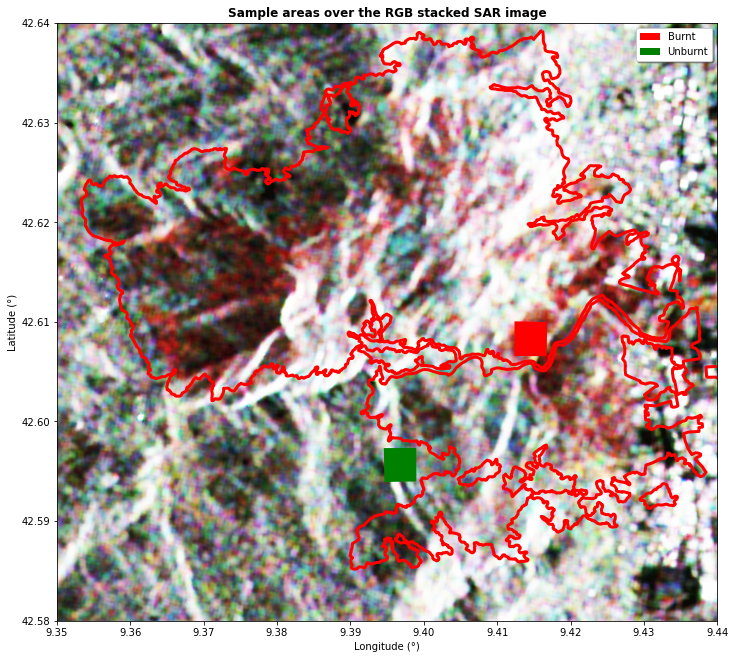

In [11]:
#Plot sub-areas
fig, ax6 = plt.subplots(figsize=(12,11))

#geoff's areas
area_in = gpd.GeoDataFrame.from_file(os.path.join("shp", "in_area3.shp"))
area_out = gpd.GeoDataFrame.from_file(os.path.join("shp", "out_area.shp"))

area_in = area_in.to_crs(crs = 4326)
area_out = area_out.to_crs(crs = 4326)
show(rgb_stretched_move, ax=ax6, transform=src.transform, title = "Sample areas over the RGB stacked SAR image")

#Add EMS borders on the plot
EMSR214_shp_wgs84 = EMSR214_shp.to_crs(crs = 4326)
EMSR214_shp_wgs84.plot(ax=ax6, facecolor='none', edgecolor='red', linewidth=3, label = "EMS")

#Add polygons on the plot
ax6 = area_in.plot(ax=ax6, facecolor='red')
ax6 =area_out.plot(ax=ax6, facecolor='green')
p_in = mpatches.Patch(facecolor='red', label= "Burnt")
p_out = mpatches.Patch(facecolor='green',label= "Unburnt")

#Set label
ax6.set_ylabel("Latitude (°)") # (WGS 84 / UTM zone 32N)
ax6.set_xlabel("Longitude (°)")
ax6.ticklabel_format(axis = 'both', style = 'plain')

#Set the extent
ax6.set_xlim(9.35, 9.44) 
ax6.set_ylim(42.58,42.64)
handles, _= ax6.get_legend_handles_labels()
ax6.legend(handles=[*handles, p_in, p_out], loc='upper right',ncol=1, shadow=True)

plt.rcParams['legend.title_fontsize'] = 10
plt.show()

For these two areas the three backscatter rasters were sampled and the mean value of backscater calculated. The plot below shows how the backscatter has changed across the three dates. As expected the backscatter for the unburnt area remain relatively constant across the three dates. For the burnt area the initial backscatter was close to the unburnt value, but this changes dramatically in the image imediately after the fire and then remains at this reduced level almost two weeks later.

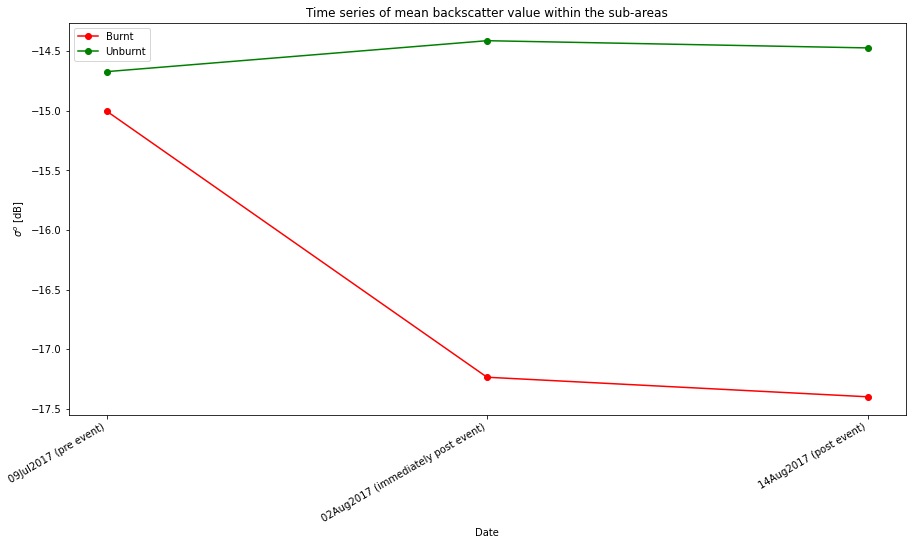

In [12]:
zs_in_series =[]
zs_out_series =[]

for n in range(src.count):
    zs_in_data = zonal_stats(area_in, S1_stack, band=n+1, stats = ["mean"], nodata = -999)
    zs_in_series.append(np.round(zs_in_data[0]['mean'],4))
    zs_out_data = zonal_stats(area_out, S1_stack, band=n+1, stats = ["mean"], nodata = -999)
    zs_out_series.append(np.round(zs_out_data[0]['mean'],4))

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(bandnames,  10.*np.log10(zs_in_series), 'o-', color='red', label= "Burnt")
ax.plot(bandnames,  10.*np.log10(zs_out_series), 'o-', color='green', label= "Unburnt")
leg = ax.legend();
ax.set_xlabel("Date")
ax.set_ylabel("$\sigma^o$ [dB]")
plt.title('Time series of mean backscatter value within the sub-areas')
fig.autofmt_xdate()

<p><img src='./img/all_partners_wekeo_2.png' align='left' alt='Logo EU Copernicus' width='100%'></img></p>